## Classification

In [1]:
from tqdm import tqdm

import medmnist
from medmnist import DermaMNIST
from medmnist import INFO, Evaluator

import matplotlib.pyplot as plt

import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

from torch.utils.data import Dataset

print(f"MedMnist v{medmnist.__version__}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # to process it on GPU rather than CPU
print(device)

MedMnist v3.0.1
cpu


### 1. Load, Preprocss and Normalize MedMNIST data
We load the data as indicated in the DermaMnist documentation.

Resizing the image (width, height) as well as the number of "color channels" (depth) is not necessary as this was already done by the XXX group. Thus only normalization and the conversion of the data to Tensors needs to be implemented.

In [2]:
# calculating the mean and std
def get_mean_and_std():
    data_transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    DataClass = getattr(medmnist, INFO['dermamnist']['python_class'])
    train_dataset = DataClass(split='train', transform=data_transform, download=True)
    train_loader = data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=False)

    mean = 0.0
    std = 0.0
    images_count = 0

    for images, _ in train_loader:
        images = images.to(device)
        batch_samples = images.size(0) # this is just the batch_size so 128, but necessary as the last batch might be smaller
        images = images.view(batch_samples, images.size(1), -1) # reshape the images to (batch_size, channels, height*width)
        mean += images.mean(2).sum(0) # sum up the mean values for each channel
        std += images.std(2).sum(0) # sum up the std dev values for each channel
        images_count += batch_samples
    
    mean /= images_count
    std /= images_count
    
    print("Mean: ", mean)
    print("Std: ", std)
    return mean, std


In [3]:
# preprocessing
def get_data_and_preprocess(mean, std, size=28):
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

    DataClass = getattr(medmnist, INFO['dermamnist']['python_class'])

    # load the data
    train_dataset = DataClass(split='train', transform=data_transform, download=True, size=size)
    test_dataset = DataClass(split='test', transform=data_transform, download=True, size=size)
    val_dataset = DataClass(split='val', transform=data_transform, download=True, size=size)
    return train_dataset, val_dataset, test_dataset

The train, validation and test data are added into DataLoader objects, to be shuffled, batched and loaded into the model during training or validation.

In [4]:
from imblearn.over_sampling import SMOTE
class CustomDataset(Dataset):
    # This is mainly to squeeze the data set, instead of needing to squeeze it later
    def __init__(self, dataset):
        self.dataset = dataset
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        data, target = self.dataset[idx]

        if not isinstance(data, torch.Tensor):
            data = torch.tensor(data, dtype=torch.float32)

        if not isinstance(target, torch.Tensor):
            target = torch.tensor(target, dtype=torch.int64) 

        target = torch.squeeze(target)

        return data, target
    
# encapsulate data into dataloader form
def load_data(train_dataset, val_dataset, test_dataset, batch_size=128):
    train_loader = data.DataLoader(dataset=CustomDataset(train_dataset), batch_size=batch_size, shuffle=True)
    train_val_loader = data.DataLoader(dataset=CustomDataset(train_dataset), batch_size=2*batch_size, shuffle=False)
    val_loader = data.DataLoader(dataset=CustomDataset(val_dataset), batch_size=2*batch_size, shuffle=False)
    test_loader = data.DataLoader(dataset=CustomDataset(test_dataset), batch_size=2*batch_size, shuffle=False)
    return train_loader, val_loader, test_loader, train_val_loader


### 2. CNN Models
##### Benchmark Model

In [5]:
class BenchmarkCNN(nn.Module):
    # define layers
    def __init__(self, num_classes):
        super(BenchmarkCNN, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.max_pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        self.fc3 = nn.Linear(576, 256)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(256,64)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(64, num_classes)
        
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.relu1(out)
        out = self.max_pool1(out)

        out = self.conv_layer2(out)
        out = self.relu2(out)
        out = self.max_pool2(out)  
        #print(out.shape)      
        out = out.reshape(out.size(0), -1)
        
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        out = self.relu4(out)
        
        out = self.fc5(out)
        return out

##### 7-Layers
For more complexity.

In [6]:
class SevenLayerCNN(nn.Module):
    # define layers
    def __init__(self, num_classes):
        super(SevenLayerCNN, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        
        self.conv_layer3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        
        self.conv_layer4 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU()
        self.max_pool4 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        self.fc5 = nn.Linear(2304, 512)
        self.relu5 = nn.ReLU()
        self.fc6 = nn.Linear(512,256)
        self.relu6 = nn.ReLU()
        self.fc7 = nn.Linear(256, num_classes)
        
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.relu1(out)
        out = self.max_pool1(out)

        out = self.conv_layer2(out)
        out = self.relu2(out)

        out = self.conv_layer3(out)
        out = self.relu3(out)

        out = self.conv_layer4(out)
        out = self.relu4(out)
        out = self.max_pool4(out)    

        out = out.reshape(out.size(0), -1)
        
        out = self.fc5(out)
        out = self.relu5(out)
        out = self.fc6(out)
        out = self.relu6(out)
        
        out = self.fc7(out)
        return out

We create the model and try to take advantage of hardware acceleration.

### 3. Define a loss and optimizer function
As we are dealing with a classification problem we use CrossEntropyLoss.

In [7]:
"""# loss function
loss_func = nn.CrossEntropyLoss()

# learning rate
lr = 0.01

# set optimiser as SGD
optimizer = torch.optim.SGD(
    model.parameters(), lr=lr
)
"""

'# loss function\nloss_func = nn.CrossEntropyLoss()\n\n# learning rate\nlr = 0.01\n\n# set optimiser as SGD\noptimizer = torch.optim.SGD(\n    model.parameters(), lr=lr\n)\n'

### 4. Training the model
To ensure we are not overfitting to the training set, we pass the validation set through the model for validation only at the end of each epoch. If we see the performance suddenly degrade while the train set performance improves, we are likely overfitting.

In [8]:
def train_model(model, loss_func, optimizer, train_loader, val_loader, num_epochs, device, show_progress=False):
    # to create a graph
    train_loss = []
    val_acc_arr = []
    val_loss = []
    
    # Actual Training Block
    for epoch in range(num_epochs):
        model.train()
        iterator = train_loader
        if show_progress:
            iterator = tqdm(train_loader)
            
        for images, labels in iterator:
            # take advanatage of gpu acceleration
            images = images.to(device)
            labels = labels.to(device)
            #labels = labels.squeeze().long()
        
            # forward propagation
            outputs = model(images)
            loss = loss_func(outputs, labels)
        
            # backward propagation and optimise
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # check validation loss
        with torch.no_grad():
            model.eval()
            correct = 0
            total = 0
            all_val_loss = []
            for images, labels in val_loader:  # change this to test data
                images = images.to(device)
                labels = labels.to(device)
                #labels = labels.squeeze().long()
            
                outputs = model(images)
                total += labels.size(0)
            
                # calculate predictions
                predicted = torch.argmax(outputs, dim=1)
                # calculate actual values
                correct += (predicted == labels).sum().item()
                # calculate the loss
                all_val_loss.append(loss_func(outputs, labels).item())
            # calculate val-loss
            mean_val_loss = sum(all_val_loss)/len(all_val_loss)
            # calculate val-accuracy
            mean_val_acc = 100 * (correct/total)
        
        if show_progress:
            print(
                'Epoch [{}/{}], Loss: {:.4f}, Val-loss: {:.4f}, Val-acc: {:.1f}%'.format(
                    epoch+1, num_epochs, loss.item(), mean_val_loss, mean_val_acc
                )
            )
        train_loss.append(loss.item())
        val_acc_arr.append(mean_val_acc)
        val_loss.append(mean_val_loss)
            
    
    if show_progress:
        print('Finished Training')


    return model, train_loss, val_acc_arr, val_loss


In [9]:
def plot_loss_chart(arr, title, y_label):
    indices = list(range(len(arr)))

    # Plotting the data
    plt.plot(indices, arr, marker='o')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(y_label)
    plt.grid(True)
    plt.show()

### 5. Test the CNN

In [10]:
# evaluation

def test(split, model, train_val_loader, val_loader, test_loader,  device):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    
    data_loader = test_loader
    if split == 'train':
        data_loader = train_val_loader
    if split == 'val':
        data_loader = val_loader

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)

            #labels = labels.squeeze().long()
            outputs = outputs.softmax(dim=-1)
            labels = labels.float().resize_(len(labels), 1)

            y_true = torch.cat((y_true, labels), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        evaluator = Evaluator('dermamnist', split)
        metrics = evaluator.evaluate(y_score)
    
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))
    return metrics.ACC

# Save the model
#torch.save(model, 'cnn.pt')

### 6. Testing Different Models
##### Benchmark Model

In [11]:
# Plotting progress data
def plot_chart(arr, title, y_label):
    indices = list(range(len(arr)))    
    plt.plot(indices, arr, marker='o')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(y_label)
    plt.grid(True)
    plt.show()

In [12]:
mean, std = get_mean_and_std()
train_dataset, val_dataset, test_dataset = get_data_and_preprocess(mean, std, size=28)
train_loader, val_loader, test_loader, train_val_loader = load_data(train_dataset, val_dataset, test_dataset, batch_size=128)
model = BenchmarkCNN(num_classes=7).to(device)

# loss function
loss_func = nn.CrossEntropyLoss()

# learning rate
lr = 0.01

# set optimiser as SGD
optimizer = torch.optim.SGD(
    model.parameters(), lr=lr
)
device = "cuda" if torch.cuda.is_available() else "cpu"
model, train_loss, val_acc_arr, val_loss = train_model(model, loss_func, optimizer, train_loader, val_loader, num_epochs=20, device=device, show_progress=False)
print('==> Evaluating ...')
test('train', model, train_val_loader, val_loader, test_loader, device)
test('val', model, train_val_loader, val_loader, test_loader, device)
test('test', model, train_val_loader, val_loader, test_loader, device)

Using downloaded and verified file: /Users/xaver/.medmnist/dermamnist.npz
Mean:  tensor([0.7631, 0.5381, 0.5614])
Std:  tensor([0.0880, 0.1144, 0.1257])
Using downloaded and verified file: /Users/xaver/.medmnist/dermamnist.npz
Using downloaded and verified file: /Users/xaver/.medmnist/dermamnist.npz
Using downloaded and verified file: /Users/xaver/.medmnist/dermamnist.npz
==> Evaluating ...
train  auc: 0.834  acc:0.697
val  auc: 0.859  acc:0.696
test  auc: 0.846  acc:0.696


0.6957605985037406

##### Testing different optimisers with different learning rates and a different number of epochs

Using downloaded and verified file: /Users/xaver/.medmnist/dermamnist.npz
Mean:  tensor([0.7631, 0.5381, 0.5614])
Std:  tensor([0.0880, 0.1144, 0.1257])
Using downloaded and verified file: /Users/xaver/.medmnist/dermamnist.npz
Using downloaded and verified file: /Users/xaver/.medmnist/dermamnist.npz
Using downloaded and verified file: /Users/xaver/.medmnist/dermamnist.npz
Learning Rate: 0.01, Optimiser: adamw, Weighted: True, Epochs: 20, train_loss: [1.9547890424728394, 1.9295600652694702, 1.94153892993927, 1.9582396745681763, 1.942344307899475, 1.9533056020736694, 1.9370352029800415, 1.9423185586929321, 1.9271066188812256, 1.941535234451294, 1.9301317930221558, 1.9555675983428955, 1.9452354907989502, 1.9442920684814453, 1.949428915977478, 1.9492287635803223, 1.9295228719711304, 1.9387205839157104, 1.9571905136108398, 1.938761591911316], val_acc_arr: [66.89930209371884, 66.89930209371884, 11.06679960119641, 11.06679960119641, 66.89930209371884, 66.89930209371884, 3.290129611166501, 11.

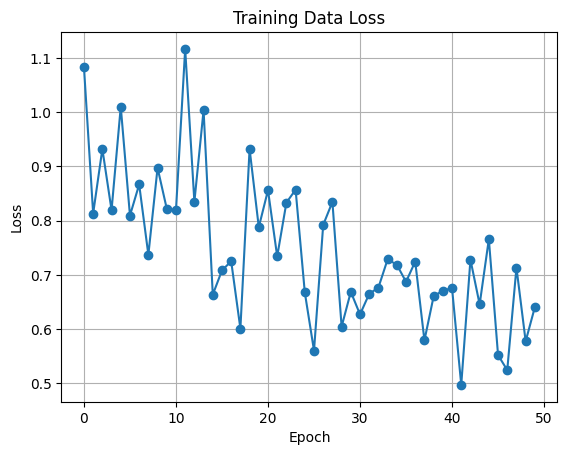

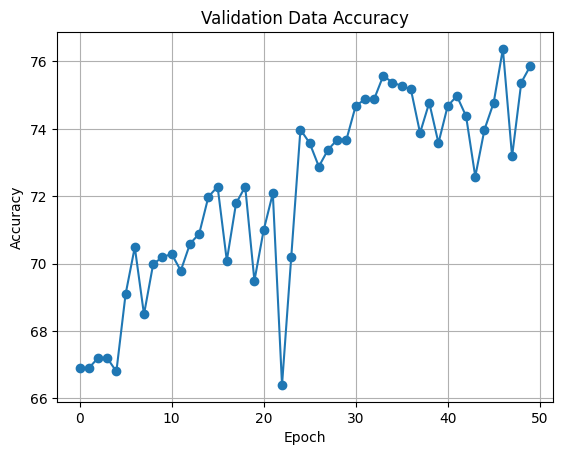

In [13]:
optimisers = ["adamw", "adam", "sgd"]
learning_rates = [0.01, 0.03, 0.05, 0.08, 0.1, 0.3, 0.5]
no_of_epochs = [20, 50, 80]
weighted_criterion = [True, False]

mean, std = get_mean_and_std()
train_dataset, val_dataset, test_dataset = get_data_and_preprocess(mean, std, size=28)
train_loader, val_loader, test_loader, train_val_loader = load_data(train_dataset, val_dataset, test_dataset, batch_size=128)

class_counts = [327, 514, 1099, 115, 1113, 6705, 142]
max_count = max(class_counts)
class_weights = [max_count / count for count in class_counts]
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

highest_acc = 0
model_with_highest_acc = {}
for lr in learning_rates:
    for opt in optimisers:
        for weighted in weighted_criterion:
            for epochs in no_of_epochs:
                # Define Parameters
                model = BenchmarkCNN(num_classes=7).to(device)
                
                if opt == "adamw":
                    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
                elif opt == "adam":
                    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
                elif opt == "sgd":
                    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
                
                loss_func = nn.CrossEntropyLoss()
                if weighted:
                    loss_func = nn.CrossEntropyLoss(weight=class_weights_tensor)
                    
                # Train the Model
                device = "cuda" if torch.cuda.is_available() else "cpu"
                try:
                    model, train_loss, val_acc_arr, val_loss = train_model(model, loss_func, optimizer, train_loader, val_loader, num_epochs=epochs, device=device, show_progress=False)
                    # Output Results
                    print(f"Learning Rate: {lr}, Optimiser: {opt}, Weighted: {weighted}, Epochs: {epochs}, train_loss: {train_loss}, val_acc_arr: {val_acc_arr}, val_loss: {val_loss}")
                    train_acc = test('train', model, train_val_loader, val_loader, test_loader, device)
                    val_acc = test('val', model, train_val_loader, val_loader, test_loader, device)
                    acc = test('test', model, train_val_loader, val_loader, test_loader, device)
                    
                    # Save the best model
                    if acc > highest_acc:
                        highest_acc = acc
                        model_with_highest_acc = {
                            "lr": lr, "opt": opt, "weighted": weighted,
                            "epochs": epochs, "train_loss":train_loss,
                            "val_acc_arr": val_acc_arr, "val_loss": val_loss,
                            "acc": acc, "val_acc": val_acc, "train_acc": train_acc
                        }
                    torch.save(model, 'basic_cnn_highest_acc.pt')
                
                except ValueError:
                    print(f"Value Error for Learning Rate: {lr}, Optimiser: {opt}, Weighted: {weighted}, Epochs: {epochs}")
                    continue

# Information on the best performing model
print(f"The best model was: {model_with_highest_acc}")
print(f"It's accuracy was {model_with_highest_acc['acc']} with validation accuracy {model_with_highest_acc['val_acc']}")
plot_chart(model_with_highest_acc["train_loss"], "Training Data Loss", "Loss")
plot_chart(model_with_highest_acc["val_acc_arr"], "Validation Data Accuracy", "Accuracy")

#### Complexer Model
##### Testing different optimisers with different learning rates and a different number of epochs

Using downloaded and verified file: /Users/xaver/.medmnist/dermamnist.npz
Mean:  tensor([0.7631, 0.5381, 0.5614])
Std:  tensor([0.0880, 0.1144, 0.1257])
Using downloaded and verified file: /Users/xaver/.medmnist/dermamnist.npz
Using downloaded and verified file: /Users/xaver/.medmnist/dermamnist.npz
Using downloaded and verified file: /Users/xaver/.medmnist/dermamnist.npz
Learning Rate: 0.01, Optimiser: sgd, Weighted: True, Epochs: 20, train_loss: [1.9429454803466797, 1.941463589668274, 1.9446086883544922, 1.9442358016967773, 1.9072434902191162, 1.8623039722442627, 1.9759080410003662, 1.7732347249984741, 1.8569135665893555, 1.7682098150253296, 1.7346450090408325, 1.700689673423767, 1.749049186706543, 1.6544291973114014, 1.681281328201294, 1.5444955825805664, 1.4981639385223389, 1.5810322761535645, 1.6884782314300537, 1.4254250526428223], val_acc_arr: [3.290129611166501, 4.3868394815553335, 12.961116650049851, 13.559322033898304, 12.26321036889332, 11.365902293120637, 13.359920239282152

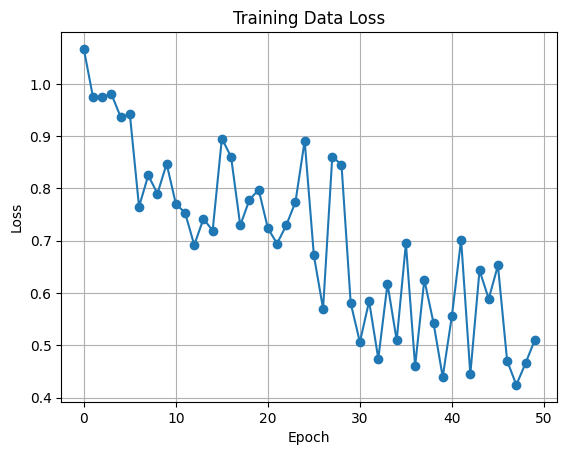

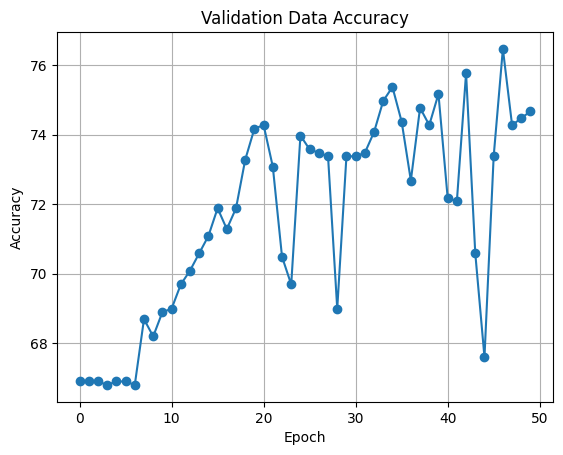

In [14]:
optimisers = ["sgd"]
learning_rates = [0.01, 0.03, 0.05, 0.08]
no_of_epochs = [20, 50, 80]
weighted_criterion = [True, False]

mean, std = get_mean_and_std()
train_dataset, val_dataset, test_dataset = get_data_and_preprocess(mean, std, size=28)
train_loader, val_loader, test_loader, train_val_loader = load_data(train_dataset, val_dataset, test_dataset, batch_size=128)

class_counts = [327, 514, 1099, 115, 1113, 6705, 142]
max_count = max(class_counts)
class_weights = [max_count / count for count in class_counts]
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

highest_acc = 0
model_with_highest_acc = {}
for lr in learning_rates:
    for opt in optimisers:
        for weighted in weighted_criterion:
            for epochs in no_of_epochs:
                # Define Parameters
                model = SevenLayerCNN(num_classes=7).to(device)
                
                if opt == "adamw":
                    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
                elif opt == "adam":
                    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
                elif opt == "sgd":
                    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
                
                loss_func = nn.CrossEntropyLoss()
                if weighted:
                    loss_func = nn.CrossEntropyLoss(weight=class_weights_tensor)
                
                # Train the Model
                device = "cuda" if torch.cuda.is_available() else "cpu"
                
                try:
                    model, train_loss, val_acc_arr, val_loss = train_model(model, loss_func, optimizer, train_loader, val_loader, num_epochs=epochs, device=device, show_progress=False)
                    
                    # Output Results
                    print(f"Learning Rate: {lr}, Optimiser: {opt}, Weighted: {weighted}, Epochs: {epochs}, train_loss: {train_loss}, val_acc_arr: {val_acc_arr}, val_loss: {val_loss}")
                    train_acc = test('train', model, train_val_loader, val_loader, test_loader, device)
                    val_acc = test('val', model, train_val_loader, val_loader, test_loader, device)
                    acc = test('test', model, train_val_loader, val_loader, test_loader, device)
                
                    # Save the best model
                    if acc > highest_acc:
                        highest_acc = acc
                        model_with_highest_acc = {
                            "lr": lr, "opt": opt, "weighted": weighted,
                            "epochs": epochs, "train_loss":train_loss,
                            "val_acc_arr": val_acc_arr, "val_loss": val_loss,
                            "acc": acc, "val_acc": val_acc, "train_acc": train_acc
                            }
                    torch.save(model, 'seven_layer_cnn_highest_acc.pt')
                
                except ValueError:
                    print(f"Value Error for Learning Rate: {lr}, Optimiser: {opt}, Weighted: {weighted}, Epochs: {epochs}")
                    continue


# Information on the best performing model
print(f"The best model was: {model_with_highest_acc}")
print(f"It's accuracy was {model_with_highest_acc['acc']} with validation accuracy {model_with_highest_acc['val_acc']}")
plot_chart(model_with_highest_acc["train_loss"], "Training Data Loss", "Loss")
plot_chart(model_with_highest_acc["val_acc_arr"], "Validation Data Accuracy", "Accuracy")

##### Looking into the impact of epochs on the previously best performing model

Using downloaded and verified file: /Users/xaver/.medmnist/dermamnist.npz
Mean:  tensor([0.7631, 0.5381, 0.5614])
Std:  tensor([0.0880, 0.1144, 0.1257])
Using downloaded and verified file: /Users/xaver/.medmnist/dermamnist.npz
Using downloaded and verified file: /Users/xaver/.medmnist/dermamnist.npz
Using downloaded and verified file: /Users/xaver/.medmnist/dermamnist.npz
==> Evaluating ...
train  auc: 1.000  acc:1.000
val  auc: 0.911  acc:0.732
test  auc: 0.908  acc:0.745


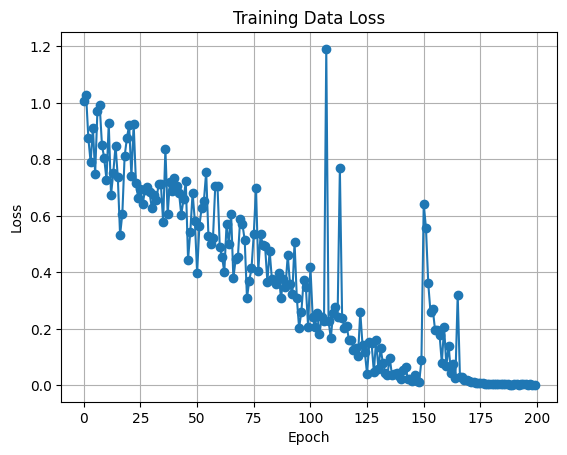

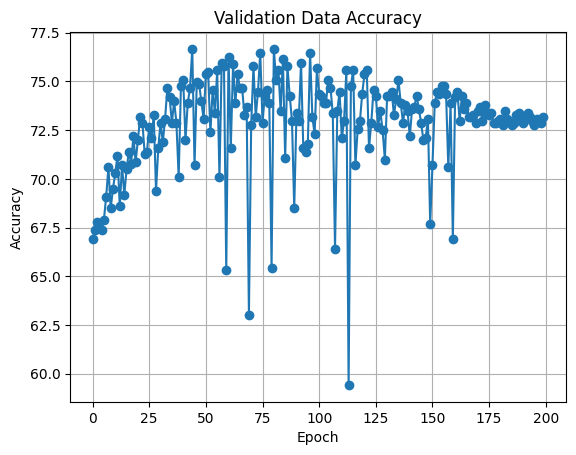

In [15]:
mean, std = get_mean_and_std()
train_dataset, val_dataset, test_dataset = get_data_and_preprocess(mean, std, size=28)
train_loader, val_loader, test_loader, train_val_loader = load_data(train_dataset, val_dataset, test_dataset, batch_size=128)
model = BenchmarkCNN(num_classes=7).to(device)

# loss function
loss_func = nn.CrossEntropyLoss()

# learning rate
lr = 0.03

# set optimiser as SGD
optimizer = torch.optim.SGD(
    model.parameters(), lr=lr
)
device = "cuda" if torch.cuda.is_available() else "cpu"
model, train_loss, val_acc_arr, val_loss = train_model(model, loss_func, optimizer, train_loader, val_loader, num_epochs=200, device=device, show_progress=False)
print('==> Evaluating ...')
test('train', model, train_val_loader, val_loader, test_loader, device)
test('val', model, train_val_loader, val_loader, test_loader, device)
test('test', model, train_val_loader, val_loader, test_loader, device)
plot_chart(train_loss, "Training Data Loss", "Loss")
plot_chart(val_acc_arr, "Validation Data Accuracy", "Accuracy")

Using downloaded and verified file: /Users/xaver/.medmnist/dermamnist.npz
Mean:  tensor([0.7631, 0.5381, 0.5614])
Std:  tensor([0.0880, 0.1144, 0.1257])
Using downloaded and verified file: /Users/xaver/.medmnist/dermamnist.npz
Using downloaded and verified file: /Users/xaver/.medmnist/dermamnist.npz
Using downloaded and verified file: /Users/xaver/.medmnist/dermamnist.npz
==> Evaluating ...
train  auc: 1.000  acc:1.000
val  auc: 0.917  acc:0.753
test  auc: 0.903  acc:0.747


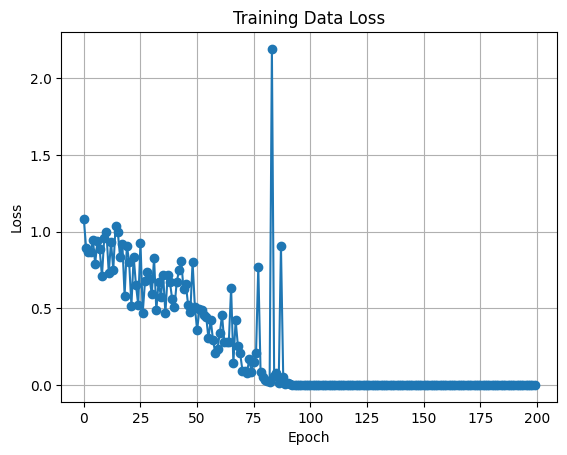

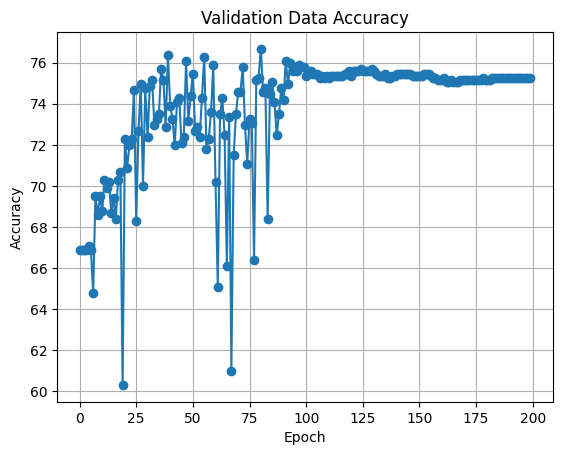

In [16]:
mean, std = get_mean_and_std()
train_dataset, val_dataset, test_dataset = get_data_and_preprocess(mean, std, size=28)
train_loader, val_loader, test_loader, train_val_loader = load_data(train_dataset, val_dataset, test_dataset, batch_size=128)
model = SevenLayerCNN(num_classes=7).to(device)

# loss function
loss_func = nn.CrossEntropyLoss()

# learning rate
lr = 0.08

# set optimiser as SGD
optimizer = torch.optim.SGD(
    model.parameters(), lr=lr
)
device = "cuda" if torch.cuda.is_available() else "cpu"
model, train_loss, val_acc_arr, val_loss = train_model(model, loss_func, optimizer, train_loader, val_loader, num_epochs=200, device=device, show_progress=False)
print('==> Evaluating ...')
test('train', model, train_val_loader, val_loader, test_loader, device)
test('val', model, train_val_loader, val_loader, test_loader, device)
test('test', model, train_val_loader, val_loader, test_loader, device)
plot_chart(train_loss, "Training Data Loss", "Loss")
plot_chart(val_acc_arr, "Validation Data Accuracy", "Accuracy")

Using downloaded and verified file: /Users/xaver/.medmnist/dermamnist.npz
Mean:  tensor([0.7631, 0.5381, 0.5614])
Std:  tensor([0.0880, 0.1144, 0.1257])
Using downloaded and verified file: /Users/xaver/.medmnist/dermamnist.npz
Using downloaded and verified file: /Users/xaver/.medmnist/dermamnist.npz
Using downloaded and verified file: /Users/xaver/.medmnist/dermamnist.npz
Epochs: 50, train_loss: [0.9896459579467773, 1.1409273147583008, 1.0385864973068237, 0.9961360692977905, 0.777103066444397, 0.9717423319816589, 0.7583010792732239, 1.0448821783065796, 0.7981569766998291, 0.819123387336731, 0.8175349235534668, 0.8174839019775391, 0.8631108999252319, 1.0090233087539673, 0.913237452507019, 0.7172088027000427, 0.676990807056427, 0.8442433476448059, 0.9072540402412415, 0.814822256565094, 0.7671929597854614, 0.6205357313156128, 0.676713228225708, 0.76633220911026, 0.6934330463409424, 0.7307924628257751, 0.6006123423576355, 0.6279627084732056, 0.8180650472640991, 0.5888756513595581, 0.788891

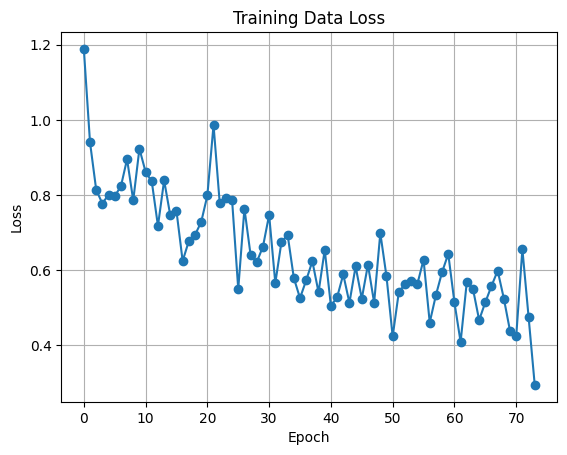

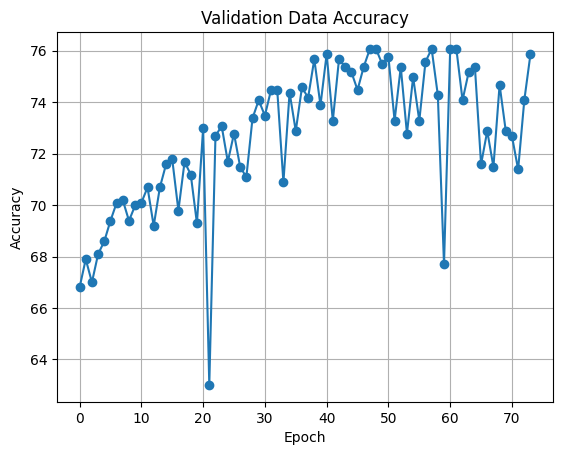

In [18]:
no_of_epochs = [50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,80]
mean, std = get_mean_and_std()
train_dataset, val_dataset, test_dataset = get_data_and_preprocess(mean, std, size=28)
train_loader, val_loader, test_loader, train_val_loader = load_data(train_dataset, val_dataset, test_dataset, batch_size=128)


model_with_highest_acc = {}
highest_acc = 0
for epochs in no_of_epochs:
    model = BenchmarkCNN(num_classes=7).to(device)

    # loss function
    loss_func = nn.CrossEntropyLoss()

    # learning rate
    lr = 0.03

    # set optimiser as SGD
    optimizer = torch.optim.SGD(
        model.parameters(), lr=lr
    )
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, train_loss, val_acc_arr, val_loss = train_model(model, loss_func, optimizer, train_loader, val_loader, num_epochs=epochs, device=device, show_progress=False)
    print(f"Epochs: {epochs}, train_loss: {train_loss}, val_acc_arr: {val_acc_arr}, val_loss: {val_loss}")
    train_acc = test('train', model, train_val_loader, val_loader, test_loader, device)
    val_acc = test('val', model, train_val_loader, val_loader, test_loader, device)
    acc = test('test', model, train_val_loader, val_loader, test_loader, device)
    
    # Save the best model
    if acc > highest_acc:
        highest_acc = acc
        model_with_highest_acc = {
            "lr": lr, "opt": opt, "weighted": weighted,
            "epochs": epochs, "train_loss":train_loss,
            "val_acc_arr": val_acc_arr, "val_loss": val_loss,
            "acc": acc, "val_acc": val_acc, "train_acc": train_acc
        }
        torch.save(model, 'benchmark_adjusted_highest_acc.pt')

# Information on the best performing model
print(f"The best model was: {model_with_highest_acc}")
print(f"It's accuracy was {model_with_highest_acc['acc']} with validation accuracy {model_with_highest_acc['val_acc']}")
plot_chart(model_with_highest_acc["train_loss"], "Training Data Loss", "Loss")
plot_chart(model_with_highest_acc["val_acc_arr"], "Validation Data Accuracy", "Accuracy")

In [ ]:
highest_acc

0.7576059850374065